In [1]:
# Para visuzalización en notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx
import community.community_louvain as cl

from sklearn.metrics import adjusted_rand_score

ModuleNotFoundError: No module named 'community'

# Tutorial de medidas de centralidad y detección de comunidades

Vamos a usar el dataset de Windsurfers que vimos antes...

Recordemos:
## Análisis de una comunidad de windsurfers

Para este tutorial vamos a utilizar los datos de dos comunidades de windsurfers en una playa del sur de California, en 1986. Los investigadores que llevaron a cabo este trabajo observaron a un grupo de 43 windsurfers durante 31 días. A partir de estas observaciones determinaron la red de contactos y además al final de las observaciones realizaron una encuesta para determinar cuáles eran las relaciones que reportaban los individuos observados.

Es decir que se pueden construir dos redes, una con las interacciones observadas y otra con las interacciones reportadas o percibidas.

Los investigadores encontraron que esta comunidad de windsurfers estaba dividida en dos sub-comunidades.
Los objetivos de nuestro análisis van a ser explorar estas redes, realizar una caracterización topológica, e intentar demostrar la presencia de las sub-comunidades.

REFERENCES

L. C. Freeman, S. C. Freeman and A. G. Michaelson "On Human Social Intelligence." Journal of Social and Biological Structures, 11, 1988, 415-425.

L. C. Freeman, S. C. Freeman and A. G. Michaelson "How Humans See Social Groups: A Test of the Sailer-Gaulin Models." Journal of Quantitative Anthropology, 1, 1989, 229-238.


## Datos
Una breve explicación del dataset está disponible aqui. Los datos están disponibles en formato DL, pero debido a que no hay una especificación formal de este formato, el parser de igraph no puede leer correctamente este dataset. Lo vamos a procesar a mano.

La información está registrada en dos matrices de adyacencia, una a continuación de la otra. La primera indica las interacciones observadas y la segunda las percibidas.

Las primeras siete lineas del archivo contienen información sobre estas matrices:

DL

N=43

NM=2

FORMAT = FULLMATRIX DIAGONAL PRESENT

LEVEL LABELS:

“bb”

“bc”

DATA:

Lo importante aqui es que hay 43 individuos, que ambas matrices son simétricas, esto va a determinar un grafo no dirigido. Las primeras siete lineas la vamos a saltear y leemos los datos en una dataframe.

In [ ]:
!wget -O windsurfers.dat https://www.dropbox.com/scl/fi/xkky45fgt6vt197b7ui6m/windsurfers.dat?rlkey=ecy1ypgdrnq2tcn1kxy426ze3&dl=1

--2024-05-02 23:48:55--  https://www.dropbox.com/scl/fi/xkky45fgt6vt197b7ui6m/windsurfers.dat?rlkey=ecy1ypgdrnq2tcn1kxy426ze3
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1678799f743ec932f6036ec5f8.dl.dropboxusercontent.com/cd/0/inline/CSLGA3y6HWIreSMLpGslO2B2A96QaWUUDsiftoMO99eb9Ew7o4lXfbuI2LOMe0NrjRH3fpy_wxP-KYitW5E6gxq5w6aPwQW7NJOzy89jqeKBgwPOJNCcdrfVvXjw4JoTmY7NwNuEL99TukJN38RMVJ9O/file# [following]
--2024-05-02 23:48:55--  https://uc1678799f743ec932f6036ec5f8.dl.dropboxusercontent.com/cd/0/inline/CSLGA3y6HWIreSMLpGslO2B2A96QaWUUDsiftoMO99eb9Ew7o4lXfbuI2LOMe0NrjRH3fpy_wxP-KYitW5E6gxq5w6aPwQW7NJOzy89jqeKBgwPOJNCcdrfVvXjw4JoTmY7NwNuEL99TukJN38RMVJ9O/file
Resolving uc1678799f743ec932f6036ec5f8.dl.dropboxusercontent.com (uc1678799f743ec932f6036ec5f8.dl.dropboxusercontent.com)... 162.125.3.15, 26

In [ ]:
ws = pd.read_csv('windsurfers.dat',skiprows=7,sep='\s+',header=None)
ws.shape

(86, 43)

In [ ]:
ws

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,8.000,0.000,0.000,0.000,2.000,4.000,0.000,1.000,0.000,0.000,...,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000
1,0.000,6.000,1.000,0.000,2.000,2.000,3.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
2,0.000,1.000,27.000,0.000,12.000,10.000,18.000,1.000,0.000,0.000,...,0.000,0.000,1.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,7.000,0.000,3.000,1.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000
4,2.000,2.000,12.000,0.000,92.000,47.000,17.000,7.000,0.000,0.000,...,0.000,0.000,0.000,0.000,11.000,1.000,0.000,7.000,0.000,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.475,0.532,0.532,0.532,0.533,0.532,0.541,0.528,0.400,0.429,...,0.385,0.375,0.519,0.429,0.532,0.000,0.519,0.510,0.452,0.500
82,0.463,0.539,0.563,0.566,0.571,0.590,0.609,0.525,0.516,0.516,...,0.579,0.538,0.588,0.456,0.535,0.519,0.000,0.529,0.568,0.479
83,0.537,0.554,0.587,0.585,0.586,0.615,0.619,0.537,0.500,0.500,...,0.333,0.333,0.500,0.500,0.565,0.510,0.529,0.000,0.571,0.500
84,0.400,0.441,0.517,0.441,0.500,0.472,0.484,0.750,0.744,0.731,...,0.638,0.591,0.684,0.538,0.516,0.452,0.568,0.571,0.000,0.569


## Construcción de las redes
La primera matriz tiene números enteros que representan el tiempo que conversaron los individuos i y j. La segunda matriz tiene números reales que representan la percepción de la cercanía que tiene el grupo sobre dos dados individuos.

La diagonal principal de la matriz ws_obs contiene datos, pero no existe información sobre su significado.

In [ ]:
ws_obs = ws.values[0:43,]

for i in range(0,43):
    ws_obs[i,i]=0

ws_per = ws.values[43:86]

for i in range(0,43):
    ws_per[i,i]=0

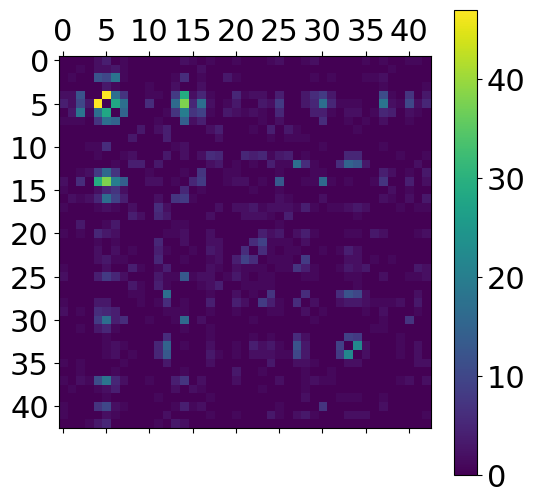

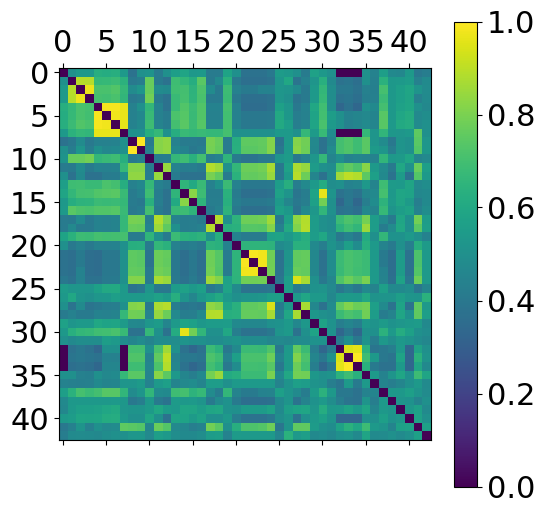

In [ ]:
plt.matshow(ws_obs)
plt.colorbar()
plt.matshow(ws_per);
plt.colorbar()

ws_obs y ws_per son ambas matrices de adyacencia y se usa la siguiente instrucción para construir el grafo

### Comenzamos con el grafo observado

In [ ]:
G_obs = nx.from_numpy_array(ws_obs)# usar opción parallel_edges=False si se usa una matriz de ints, sino puede interpretearlo como un multigrafo

###Con respecto al grafo percibido
La métrica para medir la cercanía se obtiene a partir de cuestionarios. Este valor varía entre 0 y 1. Un problema con esta codificación es que aun para individuos con muy poca interacción percibida esta variable va a tomar un valor cercano a cero, pero no cero. Al construir el grafo se tenderá una arista entre dos individuos, cuando en la practica esa interacción debería considerarse nula. Para solucionar esto vamos a considerar que cuando el valor de interacción percibida es menor de 0.5 lo convertimos a cero; esto es, no hay una interacción efectiva.

In [ ]:
umbral = 0.5
ws_per[ws_per<=umbral] = 0.0

G_per = nx.from_numpy_array(ws_per)

Alternativa: poner umbral matcheado la densidad de enlaces que se encuentran en el grafo observado

### Grafos obtenidos:
Algunas propiedades básicas

In [ ]:
print('Grafo observado:')
print(G_obs)
print('Es multigrafo?:',G_obs.is_multigraph())
print('Es dirigido?:',nx.is_directed(G_obs))
print('Es pesado?:',nx.is_weighted(G_obs))
print('Es conectado?:',nx.is_connected(G_obs))

print('')
print('Grafo percibido:')
print(G_per)
print('Es multigrafo?:',G_per.is_multigraph())
print('Es dirigido?:',nx.is_directed(G_per))
print('Es pesado?:',nx.is_weighted(G_per))
print('Es conectado?:',nx.is_connected(G_per))



Grafo observado:
Graph with 43 nodes and 336 edges
Es multigrafo?: False
Es dirigido?: False
Es pesado?: True
Es conectado?: True

Grafo percibido:
Graph with 43 nodes and 478 edges
Es multigrafo?: False
Es dirigido?: False
Es pesado?: True
Es conectado?: True


## Visualización

Elegimos una disposición (layout)

In [ ]:
layout=nx.spring_layout(G_per,iterations=1000) # elegimos como layout el grafo percibido

Text(0.5, 1.0, 'Grafo observado')

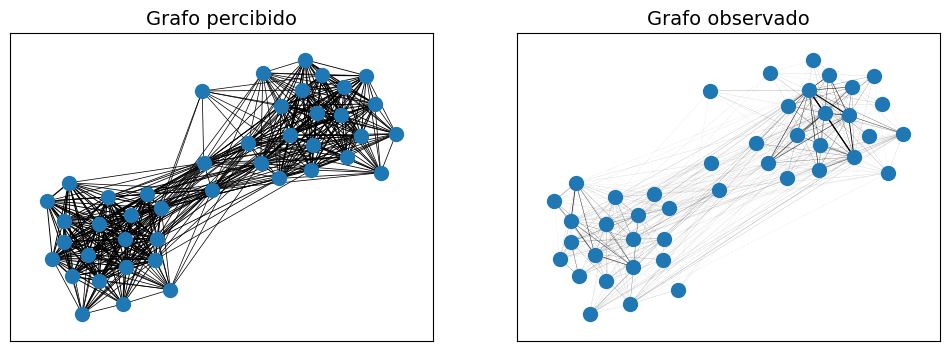

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
nx.draw_networkx_nodes(G_per, layout, node_size=100)
edge_weights_per = nx.get_edge_attributes(G_per, "weight")
edgeWitdh_per=np.array(list(edge_weights_per.values()))
nx.draw_networkx_edges(G_per, layout, edgelist=G_per.edges(),width=edgeWitdh_per)
plt.title('Grafo percibido', fontsize=14)

plt.subplot(122)
nx.draw_networkx_nodes(G_obs, layout, node_size=100)
edge_weights_obs = nx.get_edge_attributes(G_obs, "weight")
edgeWidth_obs=np.array(list(edge_weights_obs.values()))
edgeWidth_obs=edgeWidth_obs/np.max(edgeWidth_obs)
nx.draw_networkx_edges(G_obs, layout, edgelist=G_obs.edges(),width=edgeWidth_obs)
plt.title('Grafo observado', fontsize=14)

## Medidas de centralidad
Es posible calcular las medias de centralidad que vimos en lcase (ademas de la centralidad de grado):

- Grado: nx.degree_centrality

- Intermediación: nx.betweenness_centrality

- Cercanía: nx.closeness_centrality

- Centralidad de autovectores: nx.eigenvector_centrality



Observación: la centralidad de grado implementada en NetworkX **no toma en cuenta los pesos de los enlaces**...

TAREA: ¿se animan a implementarla a mano?




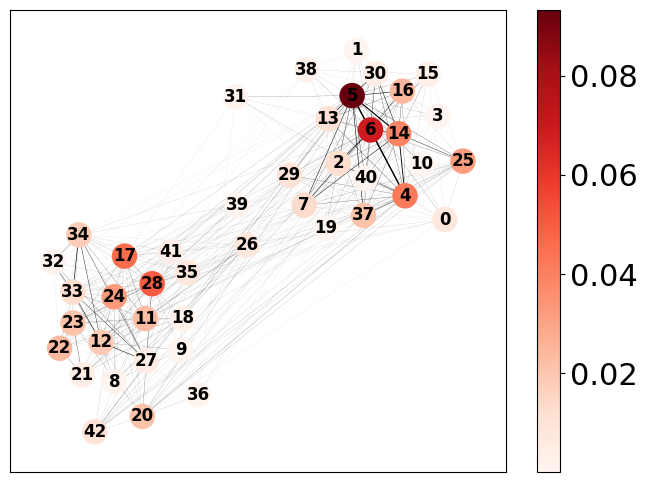

In [ ]:
# GRAFIQUEMOS LA CENTRALIDAD DE INTERMEDIACION (PESADA) DEL GRAFO OBSERVADO
centrality = nx.betweenness_centrality(G_obs)
values = [v for n,v in centrality.items()]
h=nx.draw_networkx_nodes(G_obs, layout, node_size=300, node_color = values,cmap=plt.cm.Reds)
nx.draw_networkx_labels(G_obs, layout,font_weight='bold', font_color='black')
edge_weights_obs = nx.get_edge_attributes(G_obs, "weight")
edgeWidth_obs=np.array(list(edge_weights_obs.values()))
edgeWidth_obs=edgeWidth_obs/np.max(edgeWidth_obs)
nx.draw_networkx_edges(G_obs, layout, edgelist=G_obs.edges(),width=edgeWidth_obs)
plt.colorbar(h)

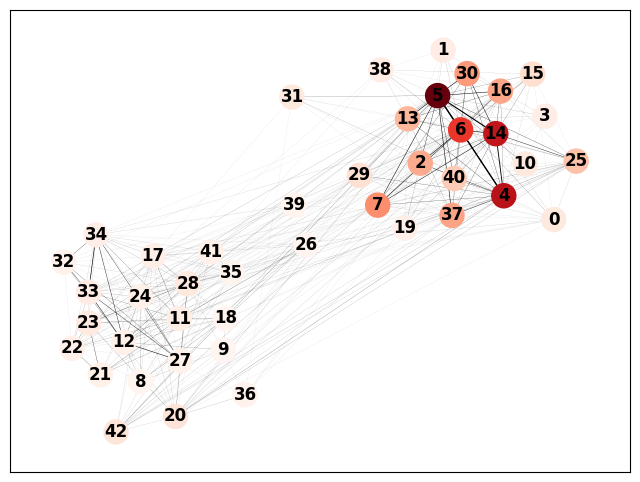

In [ ]:
# GRAFIQUEMOS LA CENTRALIDAD DE AUTOVECTOR (PESADA) DEL GRAFO OBSERVADO
centrality = nx.eigenvector_centrality(G_obs,weight='weight')
values = [v for n,v in centrality.items()]
nx.draw_networkx_nodes(G_obs, layout, node_size=300, node_color = values,cmap=plt.cm.Reds)
nx.draw_networkx_labels(G_obs, layout,font_weight='bold', font_color='black')
edge_weights_obs = nx.get_edge_attributes(G_obs, "weight")
edgeWidth_obs=np.array(list(edge_weights_obs.values()))
edgeWidth_obs=edgeWidth_obs/np.max(edgeWidth_obs)
nx.draw_networkx_edges(G_obs, layout, edgelist=G_obs.edges(),width=edgeWidth_obs)


## Comunidades

In [ ]:
def partition_set_to_dict(m):
    d = {}
    for i,c in enumerate(m):
        for n in c:
            d[n] = i
    return d

### Girvan newman

Crea grafos desconectados removiendo aristas elegidas según su valor de centralidad de aristas por cercanía (edge betweenness centrality)

In [ ]:
modulos = nx.community.girvan_newman(G_obs) # DEVUELVE UN ITERADOR modulos QUE ME DA LA COMUNIDADES QUE SURGEN AL IR ELIMINANDO ENLACES
for communities in modulos:
  print(list(communities))

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}, {9}]
[{0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}, {9}, {10}]
[{0, 1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}, {3}, {9}, {10}]
[{0, 1, 2, 4, 5, 6, 7, 13, 14, 15, 16, 19, 20, 25, 29, 30, 31, 36, 37, 38, 40, 42}, {3}, {32, 33, 34, 35, 39, 8, 41, 11, 12, 17, 18, 21, 22, 23, 24, 26, 27, 28}, {9}, {10}]
[{0, 1, 2, 4, 5, 6, 7, 13, 14, 15, 16, 19, 20, 25, 29, 30, 31, 37, 38, 40, 42}, {3}, {32, 33, 34, 35, 39, 8, 41, 11, 12, 17, 18, 21, 22, 23, 24, 26, 27, 28}, {9}, {10}, {36}]
[{0, 1, 2, 4, 5, 6, 7, 13, 14, 15, 16, 19, 20, 25, 29, 30, 31, 37, 38, 40, 42}, {3}, {32, 33, 34, 35, 8, 41, 11, 12, 17, 18, 21, 22, 23, 24, 26, 

In [ ]:
modulos = nx.community.girvan_newman(G_obs)
modularidad=[] # ESTE EL EL INDICE DE MODULARIDAD (Q) QUE QUEREMOS OPTIMIZAR
mod_max = -999
for communities in modulos:
    n_modularidad = nx.community.modularity(G_obs,tuple(sorted(c) for c in communities)) # CALCULAMOS Q PARA CADA ITERACION
    modularidad.append(n_modularidad)
    if n_modularidad>mod_max: # ME GUARDO LA MAXIMA MODULARIDAD ENCONTRADA, Y LA PARTICIÓN DE COMUNIDADES CORRESPONDIENTE
      mod_max=n_modularidad
      com_max = tuple(sorted(c) for c in communities)

k=np.argmax(modularidad)
print('La modularidad de la partición óptima es:',mod_max)
print('La partición óptima tiene ',len(com_max), ' comunidades')
print('La partición óptima es:',com_max)

La modularidad de la partición óptima es: 0.3517397809185141
La partición óptima tiene  5  comunidades
La partición óptima es: ([0, 1, 2, 4, 5, 6, 7, 13, 14, 15, 16, 19, 20, 25, 29, 30, 31, 36, 37, 38, 40, 42], [3], [8, 11, 12, 17, 18, 21, 22, 23, 24, 26, 27, 28, 32, 33, 34, 35, 39, 41], [9], [10])


¿Cómo cambia la modularidad Q a medida que vamos haciendo cortes en en el dendrograma?

Text(0, 0.5, 'Modularidad (Q)')

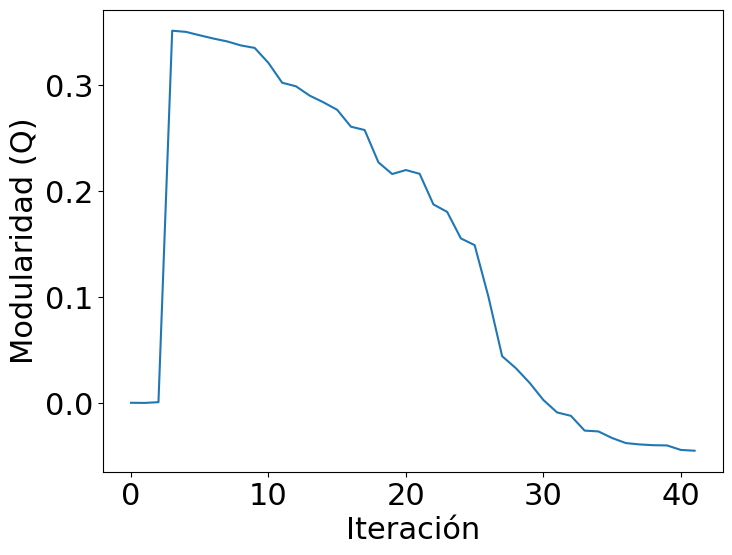

In [ ]:
plt.plot(modularidad)
plt.xlabel('Iteración')
plt.ylabel('Modularidad (Q)')

Vamos a visualizar las comunidades encontradas

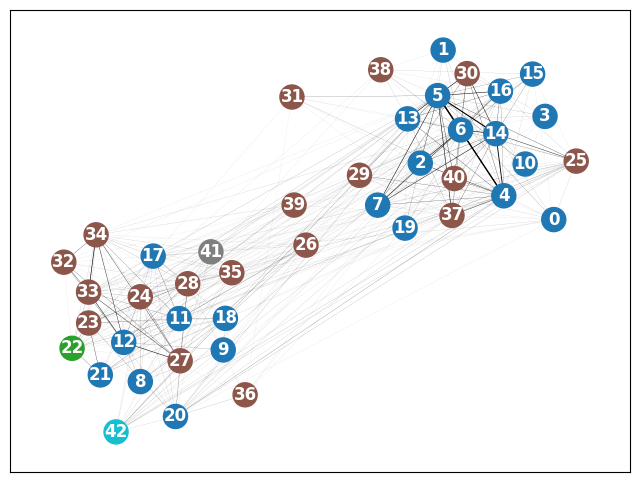

In [ ]:
values = [v for n,v in partition_set_to_dict(com_max).items()] # uso como label (color) la comunidad a la que pertenece cada nodo

plt.figure()
nx.draw_networkx_nodes(G_obs, layout, node_size=300, node_color = values,cmap=plt.cm.tab10)
nx.draw_networkx_labels(G_obs, layout,font_weight='bold', font_color='white')
edge_weights_obs = nx.get_edge_attributes(G_obs, "weight")
edgeWidth_obs=np.array(list(edge_weights_obs.values()))
edgeWidth_obs=edgeWidth_obs/np.max(edgeWidth_obs)
nx.draw_networkx_edges(G_obs, layout, edgelist=G_obs.edges(),width=edgeWidth_obs)


¿Quedó un poco ruidoso, no? Tal vez estemos forzando observar una estructura usando el layout del grafo percibido para explicar el grafo observado...
Probemos con el layout del observado:

In [ ]:
layout_obs=nx.spring_layout(G_obs,iterations=1000) # elegimos como layout el grafo observado

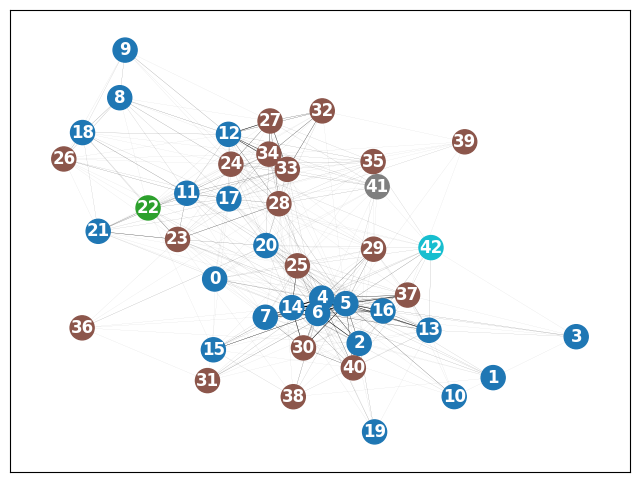

In [ ]:
plt.figure()
nx.draw_networkx_nodes(G_obs, layout_obs, node_size=300, node_color = values,cmap=plt.cm.tab10)
nx.draw_networkx_labels(G_obs, layout_obs,font_weight='bold', font_color='white')
edge_weights_obs = nx.get_edge_attributes(G_obs, "weight")
edgeWidth_obs=np.array(list(edge_weights_obs.values()))
edgeWidth_obs=edgeWidth_obs/np.max(edgeWidth_obs)
nx.draw_networkx_edges(G_obs, layout_obs, edgelist=G_obs.edges(),width=edgeWidth_obs)

Sigue muy ruidoso....

**TAREA**: buscar comunidades en el grafo percibido

### Louvian
Para el método de Louvain usamos la librería community.community_louvain que importamos como cl

Para la red Observada obtenemos:

La modularidad de la partición óptima es: 0.37121605900844046


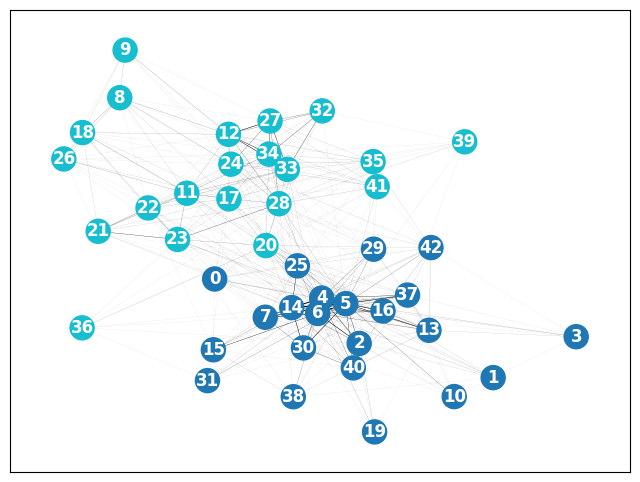

In [ ]:
modulos = cl.best_partition(G_obs)
print('La modularidad de la partición óptima es:',cl.modularity(modulos,G_obs))
values_per = [v for n,v in modulos.items()]

nx.draw_networkx_nodes(G_obs, layout_obs, node_size=300, node_color = values_per,cmap=plt.cm.tab10)
nx.draw_networkx_labels(G_obs, layout_obs,font_weight='bold', font_color='white')
edge_weights_obs = nx.get_edge_attributes(G_obs, "weight")
edgeWidth_obs=np.array(list(edge_weights_obs.values()))
edgeWidth_obs=edgeWidth_obs/np.max(edgeWidth_obs)
nx.draw_networkx_edges(G_obs, layout_obs, edgelist=G_obs.edges(),width=edgeWidth_obs)

Para la red percibida:

La modularidad de la partición óptima es: 0.38437926515088283


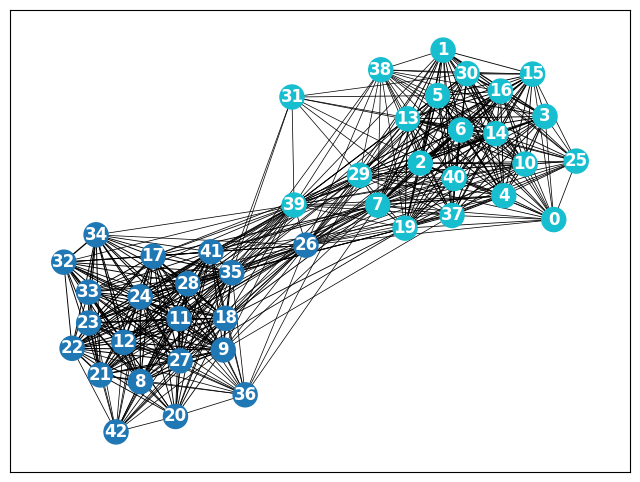

In [ ]:
modulos = cl.best_partition(G_per)
print('La modularidad de la partición óptima es:',cl.modularity(modulos,G_per))
values_obs = [v for n,v in modulos.items()]

nx.draw_networkx_nodes(G_per, layout, node_size=300, node_color = values_obs,cmap=plt.cm.tab10)
nx.draw_networkx_labels(G_per, layout,font_weight='bold', font_color='white')
edge_weights_per = nx.get_edge_attributes(G_per, "weight")
edgeWidth_per=np.array(list(edge_weights_per.values()))
edgeWidth_per=edgeWidth_per/np.max(edgeWidth_per)
nx.draw_networkx_edges(G_per, layout, edgelist=G_per.edges(),width=edgeWidth_per)

**¿Cómo comparamos ambas particiones de modularidades?**

Podemos usar el [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index), que es un índice que mide el grado de similitud entre dos particiones, donde un valor 0 indica que la similitud es igual a la de comparar dos particiones al azar, y cuanto más se acerque a 1 mayor es la similitud (Vamos a ver este índice en detalle en las clases de Clustering)


In [ ]:
adjusted_rand_score(values_obs,values_per)

0.8182848897134611